## Load pandas DataFrame & library

In [1]:
from fastai.tabular import *

In [2]:
data = pd.read_feather('titanic_cleaned_data_DataFrames')

In [3]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Last_Name,Family_Survival
0,22.0,None,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr,Braund,0.5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs,Cumings,0.5
2,26.0,None,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss,Heikkinen,0.5
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs,Futrelle,0.0
4,35.0,None,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr,Allen,0.5


Based on Random Forest Partial dependence, modify 'Fare' and 'Age'. 

## data preprocessing

In [4]:
data.Fare[data.Fare >80] = 80
data.Age[data.Age >20] = 20

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
col = ['Survived', 'Pclass', 'Sex', 'Family_Survival', 'Fare', 'Age']

In [6]:
data = data[col]

In [7]:
data.head()

,Survived,Pclass,Sex,Family_Survival,Fare,Age
0,0.0,3,0,0.5,7.2500,20.0
1,1.0,1,1,0.5,71.2833,20.0
2,1.0,3,1,0.5,7.9250,20.0
3,1.0,1,1,0.0,53.1000,20.0
4,0.0,3,0,0.5,8.0500,20.0


In [8]:
def split_data(a,n): return a[:n].copy(), a[n:].copy()
train_df, test_df = split_data(data,891)
test_df.drop('Survived', axis = 1, inplace = True)
train_df.Survived = train_df.Survived.astype(int)

In [9]:
procs = [FillMissing, Categorify, Normalize]
cat_names = ['Pclass', 'Sex', 'Family_Survival']
cont_names = ['Fare', 'Age']
dep_var = 'Survived'

data = (TabularList.from_df(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names)
        .split_by_idx(valid_idx=range(int(len(train_df)*0.9),len(train_df)))
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(test_df, cat_names=cat_names, procs=procs, cont_names=cont_names))
        .databunch())

In [10]:
data.show_batch(rows=10)

Pclass,Sex,Family_Survival,Fare,Age,target
2,1,0.5,-0.6400,0.3521,1
3,1,1.0,-0.4227,-4.1182,1
1,1,1.0,2.2413,0.3521,1
1,1,1.0,1.3284,0.3521,1
2,0,0.0,1.9718,-0.1185,0
1,0,0.5,0.5664,0.3521,0
1,1,1.0,1.2048,0.3521,1
3,0,0.5,-0.7415,0.3521,0
3,0,0.5,-0.7467,0.3521,1
3,1,0.0,-0.4760,0.3521,0


## set up deep learning model

In [11]:
learn = tabular_learner(data,layers=[400,100], metrics=accuracy)

## training model

In [12]:
learn.fit_one_cycle(5, 2.5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.643272,0.620372,0.633333,00:00
1,0.544305,0.407770,0.822222,00:00
2,0.487724,0.370197,0.855556,00:00
3,0.450300,0.335145,0.855556,00:00
4,0.426148,0.325564,0.855556,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


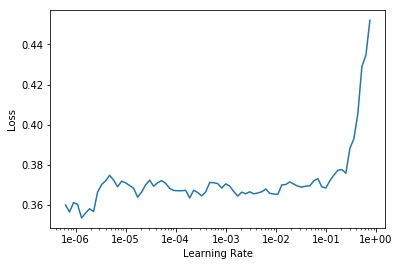

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.356537,0.325466,0.855556,00:00
1,0.368534,0.326309,0.855556,00:00
2,0.365827,0.324341,0.855556,00:00
3,0.368844,0.324072,0.855556,00:00
4,0.369362,0.324522,0.855556,00:00


## prediction

In [15]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
pred_prob, pred_class = preds.max(1)

In [16]:
path = '/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/titanic/'

In [17]:
submmit = pd.read_csv(path+'gender_submission.csv')

In [18]:
submmit['Survived'] = pred_class
submmit.to_csv(path+'gender_submission.csv', index=False)

Public Score: 0.81339

In [20]:
! kaggle competitions submit titanic -f {path+'gender_submission.csv'} -m "My submission-DL-test4"

100%|████████████████████████████████████████| 2.77k/2.77k [00:11<00:00, 253B/s]
Successfully submitted to Titanic: Machine Learning from Disaster